In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import contextily as ctx
import pathlib
import numpy as np
import math
import networkx as nx
import random
import folium
import shapely
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [2]:
# Forecasts
day1_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_forecasts_2023.geojson')

In [3]:
day2_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day2/day2_forecasts_2023.geojson')

In [4]:
day3_forecast = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day3/day3_forecasts_2023.geojson')

In [5]:
random_color = lambda: np.random.random(3)

In [6]:
# look at the forecasts
day2_forecast

prediction  forecastHour            datetime  maxWinds  category  \
0             1            12 2023-08-03 14:00:00        90         2   
1             1            24 2023-08-04 02:00:00       100         3   
2             1            36 2023-08-04 14:00:00       100         3   
3             1            48 2023-08-05 02:00:00        85         2   
4             1            60 2023-08-05 14:00:00        90         2   
..          ...           ...                 ...       ...       ...   
155          20            48 2023-08-05 02:00:00        85         2   
156          20            60 2023-08-05 14:00:00        90         2   
157          20            72 2023-08-06 02:00:00        70         1   
158          20            96 2023-08-07 02:00:00        55         0   
159          20           120 2023-08-08 02:00:00        30         0   

                       geometry  
0    POINT (-71.08364 40.10039)  
1    POINT (-71.20753 40.57195)  
2    POINT (-71.57037 41.03901)  
3    POINT (-71.56239 41.78819)  
4    POINT (-71.82221 43.03099)  
..                          ...  
155  POINT (-71.31454 42.18478)  
156  POINT (-71.45722 44.98515)  
157  POINT (-71.66635 43.23327)  
158  POINT (-69.51318 43.31826)  
159  POINT (-66.86106 42.55622)  

[160 rows x 6 columns]

/tmp/ipykernel_227/137355085.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  circle = pred.buffer(0.5)


ValueError: Unknown column LINESTRING (-71.4427000202242 42.355262003307914, -70.95989533170732 43.298337884477796, -70.13339433966823 43.859756405651424, -68.53599203223692 43.32474516713234, -68.05749860139848 43.94382358648027, -67.62107604546615 44.02198412529351)

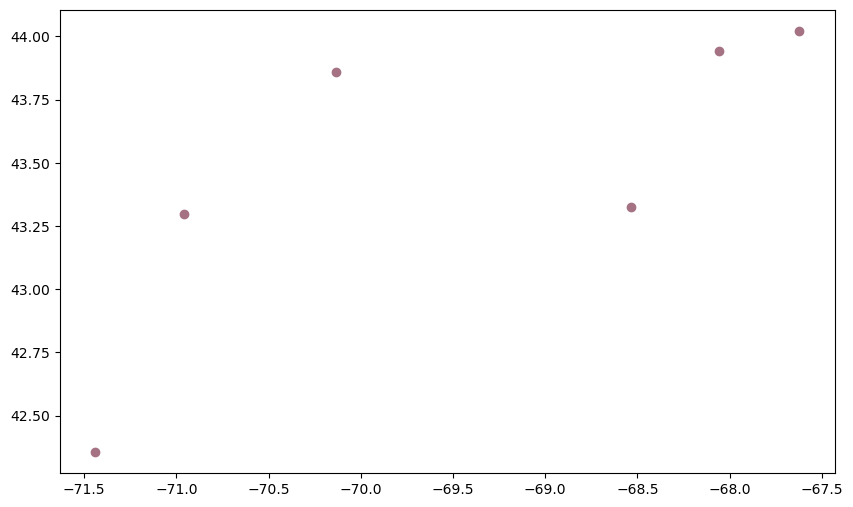

In [7]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in day3_forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    circle = pred.buffer(0.5)
    line_to_plot = LineString(pred.geometry.values)
    gdf1 = gpd.GeoDataFrame(geometry=line_to_plot)
    gdf.plot(ax=ax)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], label=f'{pred_id}')
ax.legend(title='prediction id')

In [ ]:
gdf

<Axes: >

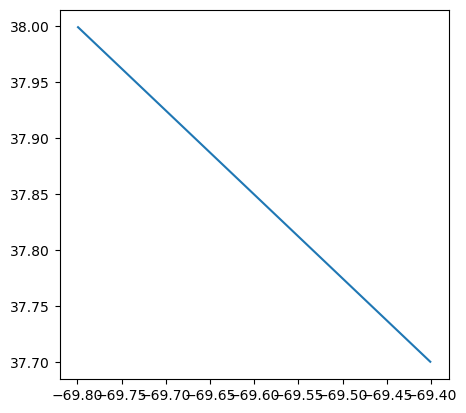

In [8]:
# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/day1/day1_track_past.geojson')
day1_track.plot()

# Location of Areas of Interest


In [5]:
!wget https://files.bwsi-remote-sensing.net/data/final/Hospitals_2023.geojson
!wget https://files.bwsi-remote-sensing.net/data/final/Shelters_2023.geojson

--2023-08-02 14:21:10--  https://files.bwsi-remote-sensing.net/data/final/Hospitals_2023.geojson
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 44.239.18.13, 54.213.96.119, 52.11.178.22, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|44.239.18.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 363649 (355K)
Saving to: ‘Hospitals_2023.geojson’

Hospitals_2023.geoj 100%[===================>] 355.13K  --.-KB/s    in 0.008s  

2023-08-02 14:21:10 (42.6 MB/s) - ‘Hospitals_2023.geojson’ saved [363649/363649]

--2023-08-02 14:21:11--  https://files.bwsi-remote-sensing.net/data/final/Shelters_2023.geojson
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 44.239.18.13, 35.162.52.213, 52.11.178.22, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|44.239.18.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9360630 (8.9M)
Saving t

In [9]:
hospitals_gdf = gpd.read_file('Hospitals_2023.geojson')
shelters_gdf = gpd.read_file('Shelters_2023.geojson')

In [11]:
shelters_gdf['EVACUATION_CAPACITY']

0       400.0
1         0.0
2       300.0
3         0.0
4         0.0
        ...  
4580      NaN
4581      NaN
4582      NaN
4583      NaN
4584      NaN
Name: EVACUATION_CAPACITY, Length: 4585, dtype: float64

# Game Grid
This is the grid that represents the scope of the response, and also the transportation network
It uses the [Military Grid Reference System](https://en.wikipedia.org/wiki/Military_Grid_Reference_System) to divide the world into a grid. There is a unique alphanumeric string that identifies each cell. We are working at the 1km resolution of the grid. See also the [US National Grid](https://www.fgdc.gov/usng/how-to-read-usng) which is nearly identical, except for some [edge-cases](https://www.maptools.com/tutorials/mgrs_usng_diffs).

The `MGRS` column is a unique alphanumeric ID for each cell. It should be used as your node ID for your transport network.

In [2]:
# downloading pre-hurricane game grid (pretty big file ~ 111 MB)
!wget https://files.bwsi-remote-sensing.net/data/final/game_grid_2023.geojson

--2023-08-02 14:19:59--  https://files.bwsi-remote-sensing.net/data/final/game_grid_2023.geojson
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 44.239.18.13, 52.11.178.22, 54.213.96.119, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|44.239.18.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116721567 (111M)
Saving to: ‘game_grid_2023.geojson’

game_grid_2023.geoj 100%[===================>] 111.31M   237MB/s    in 0.5s    

2023-08-02 14:20:00 (237 MB/s) - ‘game_grid_2023.geojson’ saved [116721567/116721567]



In [10]:
game_grid = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/game_grid_2023_post_event.geojson')

In [7]:
game_grid

EASTING   NORTHING kmSQ_ID  GZD     Shape_Leng       MGRS MGRS_10km  \
0       596000mE  4984000mN      WQ  18T  400000.000000  18TWQ9684   18TWQ98   
1       597000mE  4984000mN      WQ  18T  400000.000000  18TWQ9784   18TWQ98   
2       598000mE  4984000mN      WQ  18T  400000.000000  18TWQ9884   18TWQ98   
3       599000mE  4984000mN      WQ  18T  400000.000000  18TWQ9984   18TWQ98   
4       579000mE  4983000mN      WQ  18T  400000.000000  18TWQ7983   18TWQ78   
...          ...        ...     ...  ...            ...        ...       ...   
232562  282000mE  4558000mN      BF  19T       0.041828  19TBF8258   19TBF85   
232563  283000mE  4558000mN      BF  19T       0.041828  19TBF8358   19TBF85   
232564  284000mE  4558000mN      BF  19T       0.041828  19TBF8458   19TBF85   
232565  285000mE  4558000mN      BF  19T       0.041828  19TBF8558   19TBF85   
232566  286000mE  4558000mN      BF  19T       0.041829  19TBF8658   19TBF85   

        transport_score                                           geometry  
0                     1  POLYGON ((-73.76921 45.00282, -73.78190 45.002...  
1                     1  POLYGON ((-73.75653 45.00268, -73.76921 45.002...  
2                     1  POLYGON ((-73.74384 45.00254, -73.75653 45.002...  
3                     1  POLYGON ((-73.73116 45.00240, -73.74384 45.002...  
4                     1  POLYGON ((-73.98504 44.99594, -73.99773 44.996...  
...                 ...                                                ...  
232562                1  POLYGON ((-71.58574 41.14431, -71.59765 41.144...  
232563                1  POLYGON ((-71.57384 41.14458, -71.58574 41.144...  
232564                1  POLYGON ((-71.56193 41.14484, -71.57384 41.144...  
232565                1  POLYGON ((-71.55003 41.14511, -71.56193 41.144...  
232566                1  POLYGON ((-71.53813 41.14537, -71.55003 41.145...  

[232567 rows x 9 columns]

## Overall bounds of map
Useful for all teams to find additional GIS and remote sensing resources to use

In [11]:
w,s,e,n = game_grid.total_bounds
print(w,s,e,n)

-74.0062751207002 40.995556258214776 -66.93832921282291 47.46624330268622


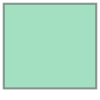

In [12]:
polygon = Polygon([(w,s), (w,n), (e,n), (e,s)])
polygon

In [21]:
game_grid

MGRS   EASTING   NORTHING kmSQ_ID  GZD     Shape_Leng MGRS_10km  \
0       18TWL8392  583000mE  4592000mN      WL  18T  400000.000000   18TWL89   
1       18TWL8393  583000mE  4593000mN      WL  18T  400000.000000   18TWL89   
2       18TWL8394  583000mE  4594000mN      WL  18T  400000.000000   18TWL89   
3       18TWL8395  583000mE  4595000mN      WL  18T  400000.000000   18TWL89   
4       18TWL8396  583000mE  4596000mN      WL  18T  400000.000000   18TWL89   
...           ...       ...        ...     ...  ...            ...       ...   
196817  19TFL4402  644000mE  5002000mN      FL  19T       0.043441   19TFL40   
196818  19TFL4500  645000mE  5000000mN      FL  19T       0.043433   19TFL40   
196819  19TFL4501  645000mE  5001000mN      FL  19T       0.043437   19TFL40   
196820  19TFL4502  645000mE  5002000mN      FL  19T       0.043441   19TFL40   
196821  19TFL4600  646000mE  5000000mN      FL  19T       0.043432   19TFL40   

        transport_score   DN wind_speed  \
0                   1.0  NaN        NaN   
1                   0.1  7.0        NaN   
2                   0.2  7.0        NaN   
3                   0.3  8.0        NaN   
4                  10.0  2.0        NaN   
...                 ...  ...        ...   
196817              1.0  NaN         TS   
196818              0.9  NaN         TS   
196819              0.9  NaN         TS   
196820              1.0  NaN         TS   
196821              0.1  9.0         TS   

                                                 geometry  
0       POLYGON ((-73.99395 41.47521, -74.00593 41.475...  
1       POLYGON ((-73.99381 41.48421, -74.00579 41.484...  
2       POLYGON ((-73.99367 41.49322, -74.00565 41.493...  
3       POLYGON ((-73.99354 41.50222, -74.00552 41.502...  
4       POLYGON ((-73.99340 41.51123, -74.00538 41.511...  
...                                                   ...  
196817  POLYGON ((-67.15522 45.15658, -67.16794 45.156...  
196818  POLYGON ((-67.14309 45.13838, -67.15580 45.138...  
196819  POLYGON ((-67.14280 45.14738, -67.15551 45.147...  
196820  POLYGON ((-67.14251 45.15637, -67.15522 45.156...  
196821  POLYGON ((-67.13038 45.13817, -67.14309 45.138...  

[196822 rows x 11 columns]

In [13]:
#AIRFIELDS GEODATAFRAMES
airfields = ox.features.features_from_polygon(polygon, tags={'aeroway': 'aerodrome'}) #polygon is the bound-box

us_airfields = airfields.loc[airfields['addr:state'].isnull() == False] #removes airports without state to isolatew within us bounds\

In [14]:
us_airfields = us_airfields.dropna(subset=['name'])
us_airfields[us_airfields['addr:state'].str.contains('ME', case=False)]

nodes  \
element_type osmid                                                           
way          91364029    [1060655993, 1060655895, 9279224189, 927922418...   
             715817903   [6726999534, 6726999533, 6726999532, 672699953...   
             930047542   [369072623, 8624396073, 8624396074, 8624396076...   
node         369071435                                                 NaN   
             369072486                                                 NaN   
...                                                                    ...   
way          533080210   [369071164, 5172256215, 5172256214, 5172256213...   
relation     11489562    [[[6854302750, 6854302751, 6854302752, 6854302...   
node         1042047850                                                NaN   
             369072493                                                 NaN   
             369072498                                                 NaN   

                         FAA:LFSN addr:state    aeroway  ele   faa  \
element_type osmid                                                   
way          91364029    07963.*A         ME  aerodrome   15   EPM   
             715817903        NaN         ME  aerodrome   17   ME2   
             930047542        NaN         ME  aerodrome   15   NaN   
node         369071435        NaN         ME  aerodrome  121  ME06   
             369072486        NaN         ME  aerodrome   55  ME88   
...                           ...        ...        ...  ...   ...   
way          533080210        NaN         ME  aerodrome  170  03ME   
relation     11489562         NaN         ME  aerodrome  198   0B1   
node         1042047850       NaN         ME  aerodrome  NaN  ME17   
             369072493        NaN         ME  aerodrome  556   8B0   
             369072498        NaN         ME  aerodrome  463   NaN   

                        gnis:feature_id  icao  \
element_type osmid                              
way          91364029            582144  KEPM   
             715817903           582137   NaN   
             930047542           582179   NaN   
node         369071435           582130   NaN   
             369072486           582205   NaN   
...                                 ...   ...   
way          533080210           582159   NaN   
relation     11489562            579861   NaN   
node         1042047850             NaN   NaN   
             369072493           582219   NaN   
             369072498           582220   NaN   

                                                     name start_date  ...  \
element_type osmid                                                    ...   
way          91364029          Eastport Municipal Airport    1942-12  ...   
             715817903            Cutler Regional Airport        NaN  ...   
             930047542            Lubec Municipal Airport        NaN  ...   
node         369071435                  Flying Ed Airport        NaN  ...   
             369072486                 Morrison's Airport        NaN  ...   
...                                                   ...        ...  ...   
way          533080210                Maple Ridge Airport        NaN  ...   
relation     11489562             Bethel Regional Airport        NaN  ...   
node         1042047850                    Thomas Airport        NaN  ...   
             369072493   Steven A. Bean Municipal Airport        NaN  ...   
             369072498        Rangeley Lake Seaplane Base        NaN  ...   

                        name:ar name:de name:es name:fa name:fi name:uk  \
element_type osmid                                                        
way          91364029       NaN     NaN     NaN     NaN     NaN     NaN   
             715817903      NaN     NaN     NaN     NaN     NaN     NaN   
             930047542      NaN     NaN     NaN     NaN     NaN     NaN   
node         369071435      NaN     NaN     NaN     NaN     NaN     NaN   
             369072486      NaN     NaN     NaN     N

In [182]:
# This is the explore map with the hospitals, shelters, airfields, and predictions

import folium
# Reset map variable
airmap = folium.Map()

# Add hospital, shelter, and airfield data
airmap = hospitals_gdf[['ID', 'NAME','ADDRESS','STATE','geometry']].explore(m=airmap, color = 'red', name= 'hospitals', style_kwds = {'weight':.3})
airmap = shelters_gdf[['SHELTER_ID','SHELTER_NAME','ADDRESS_1','STATE','geometry']].explore(m=airmap, color = 'blue', name= 'shelters', style_kwds = {'weight':.3})
airmap = us_airfields[['geometry', 'addr:state', 'aeroway', 'faa', 'name']].explore(m=airmap, name= 'airfields', color = 'green', style_kwds = {'weight':2})

#Separates forecast paths and puts it in a singular geodataframe
paths_arr = []
for pred_id, pred in day1_forecast.groupby('prediction'):
    line_to_plot = LineString(pred.geometry.values)
    paths_arr.append({'prediction': pred_id, 'geometry':line_to_plot})
paths_df = gpd.GeoDataFrame(paths_arr)

#Plots individual hurricane paths
airmap = day1_forecast[['prediction','forecastHour','maxWinds','category','geometry']].explore('prediction', m = airmap, name = 'points', legend = False)
airmap = paths_df.explore('prediction', m= airmap, name= 'paths')

# Add bounding box
bounding_box_gdf = folium.Rectangle([[s,w],[n,e]]) 
airmap.add_child(bounding_box_gdf)

# Set default bounds
airmap.fit_bounds([[s,w],[n,e]]) 
airmap

In [ ]:
# This is the normal map with the hospitals, shelters, airfields, roads, and predictions

bounding_box_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

fig, ax = plt.subplots(figsize=(10,10))

game_grid.to_crs(epsg=3857).plot(ax=ax, column='transport_score')

# Plot the bounding box
bounding_box_gdf.to_crs(epsg=3857).plot(ax=ax, color='none', edgecolor='red', linewidth=2, label='Bounding Box')

# Plot the shelters
shelters_gdf.to_crs(epsg=3857).plot(ax=ax, color='white', markersize=5, label='Shelters', alpha=0.2)

# Plot the hospitals
hospitals_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', markersize=5, label='Hospitals', alpha=0.2)

# Plot the hurricane predictions
for pred_id, pred in day3_forecast.groupby('prediction'):
    pred.to_crs(epsg=3857).plot(color='purple', markersize=5, ax=ax)
    line_to_plot = LineString(day3_forecast.geometry.values)
    line_gdf = gpd.GeoDataFrame(geometry=[line_to_plot], crs="EPSG:4326")
    line_gdf = line_gdf.to_crs(epsg=3857)
    line_gdf.plot(color='blue', ax=ax, label='LineString')
    
centers.plot(ax=ax, color='red', markersize=15, label='Airfields', alpha=0.5)

#us_airfields.loc[us_airfields['name'] == 'Westover Air Reserve Base'].to_crs(epsg=3857).plot(ax=ax, color='green', markersize=10, label='Westover', alpha=0.8)

plt.axis([-8250000,-7250000,4500000,6000000])

plt.show()

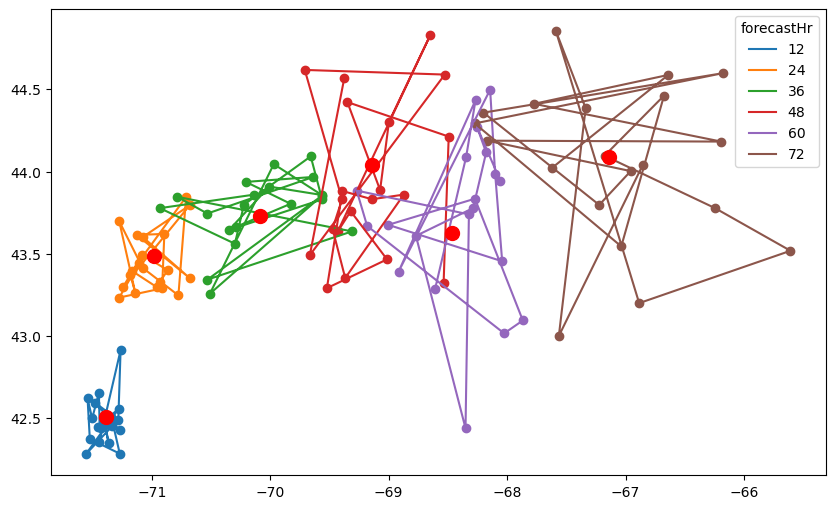

In [196]:
from shapely.geometry import Point, LineString, MultiPolygon

fig, ax = plt.subplots(1, 1, figsize=(10,10))
all_centroid = []
all_points = []

for pred_id, pred in day3_forecast.groupby('forecastHour'):
    #c = random_color()
    pred.plot(ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], label=f'{pred_id}')
    all_points.append(pred.geometry.values)
    
    l_centroid = line_to_plot.centroid
    l_centroid_x, l_centroid_y = l_centroid.xy
    ax.plot(l_centroid_x, l_centroid_y, 'ro', markersize=10)
    centroid = Point(l_centroid_x,l_centroid_y)
    all_centroid.append(centroid)
    
ax.legend(title='forecastHr')

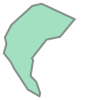

In [18]:
import shapely

all_points_12 = Polygon([[p.x, p.y] for p in all_points[0]])
all_points_12 = all_points_12.convex_hull

all_points_24 = Polygon([[p.x, p.y] for p in all_points[1]])
all_points_24 = all_points_24.convex_hull

all_points_36 = Polygon([[p.x, p.y] for p in all_points[2]])
all_points_36 = all_points_36.convex_hull

all_points_48 = Polygon([[p.x, p.y] for p in all_points[3]])
all_points_48 = all_points_48.convex_hull

all_points_60 = Polygon([[p.x, p.y] for p in all_points[4]])
all_points_60 = all_points_60.convex_hull

all_points_72 = Polygon([[p.x, p.y] for p in all_points[5]])
all_points_72 = all_points_72.convex_hull

all_points_96 = Polygon([[p.x, p.y] for p in all_points[6]])
all_points_96 = all_points_96.convex_hull

all_points_120 = Polygon([[p.x, p.y] for p in all_points[7]])
all_points_120 = all_points_120.convex_hull

#show each separate polygon
all = MultiPolygon([all_points_12, all_points_24, all_points_36, all_points_48, all_points_60, all_points_72, all_points_96, all_points_120])

fc12_24 = MultiPolygon([all_points_12, all_points_24]).convex_hull
fc24_36 = MultiPolygon([all_points_24, all_points_36]).convex_hull
fc36_48 = MultiPolygon([all_points_36, all_points_48]).convex_hull
fc48_60 = MultiPolygon([all_points_48, all_points_60]).convex_hull
fc60_72 = MultiPolygon([all_points_60, all_points_72]).convex_hull
fc72_96 = MultiPolygon([all_points_72, all_points_96]).convex_hull
fc96_120 = MultiPolygon([all_points_96, all_points_120]).convex_hull

all_forecasts = shapely.union_all([fc12_24, fc24_36, fc36_48, fc48_60, fc60_72, fc72_96, fc96_120])
all_forecasts

In [10]:
#update hospital, shelter, and airfield data (uses planning team data)
hospitals_gdf['affected?'] = shapely.intersects(hospitals_gdf['geometry'], all_forecasts)
shelters_gdf['affected?'] = shapely.intersects(shelters_gdf['geometry'], all_forecasts)
us_airfields['affected?'] = shapely.intersects(us_airfields['geometry'], all_forecasts)

#create geodataframe with desired airports
airport_list = ['Westover Air Reserve Base'] #replace list with list of names
names_of_airports = pd.DataFrame({'name': airport_list})
selected_airfields_gdf = us_airfields.merge(names_of_airports, how = 'inner', on = 'name')

#create geodataframe of hurricane paths 
paths_arr = []
for pred_id, pred in day1_forecast.groupby('prediction'):
    line_to_plot = LineString(pred.geometry.values)
    paths_arr.append({'prediction': pred_id, 'geometry':line_to_plot})
paths_df = gpd.GeoDataFrame(paths_arr)

#create geodataframe using cone of uncertainty
cone_of_uncertainty = gpd.GeoDataFrame(geometry = [all_forecasts])
cone_of_uncertainty.loc[0, 'hurricane'] = 'hurricane'

NameError: name 'all_forecasts' is not defined

In [22]:
# Reset map variable
airmap = folium.Map()

# Add hospital, shelter, and airfield data
airmap = hospitals_gdf[['ID', 'NAME','ADDRESS','STATE','affected?','geometry']].explore(m=airmap, color = 'red', name= 'hospitals', style_kwds = {'weight':.3})
airmap = shelters_gdf[['SHELTER_ID','SHELTER_NAME','ADDRESS_1','STATE','affected?','geometry']].explore(m=airmap, color = 'blue', name= 'shelters', style_kwds = {'weight':.3})
airmap = us_airfields[['geometry', 'addr:state', 'aeroway', 'faa','affected?', 'name']].explore(m=airmap, name= 'airfields', color = 'green', style_kwds = {'weight':2})
#airmap = selected_airfields_gdf[['geometry', 'addr:state', 'aeroway', 'faa','affected?', 'name']].explore(m= airmap, name= 'distribution centers', color = 'brown', style_kwds = {'weight':3}))


#add hurricane path
airmap = day1_forecast[['prediction','forecastHour','maxWinds','category','geometry']].explore('prediction', m = airmap, name = 'points', legend = False) #points share same legend with paths
airmap = paths_df.explore('prediction', m=airmap, name= 'paths')

#add hurricane shape
airmap = cone_of_uncertainty.explore(m=airmap, color = 'yellow', style_kwds = {'opacity':.22, 'fillOpacity':.22, 'fillColor': 'yellow'}, name = 'storm')

# Add bounding box
bounding_box_gdf = folium.Rectangle([[s,w],[n,e]]) 
airmap.add_child(bounding_box_gdf)

# Set default bounds
airmap.fit_bounds([[s,w],[n,e]]) 

#add layers
folium.LayerControl().add_to(airmap)
airmap

## Get the cells neighboring each cell
Buffer and use spatial join with `overlap` to find which cells are neighboring each other

In [8]:
buffered_game_grid = game_grid.to_crs('epsg:3857')
buffered_game_grid.geometry = buffered_game_grid.buffer(10)
neighboring_gdf = gpd.sjoin(buffered_game_grid, game_grid.to_crs('epsg:3857'), predicate='overlaps')

In [26]:
neighboring_gdf

EASTING_left NORTHING_left kmSQ_ID_left GZD_left  Shape_Leng_left  \
0          596000mE     4984000mN           WQ      18T    400000.000000   
19         594000mE     4983000mN           WQ      18T    400000.000000   
21         596000mE     4983000mN           WQ      18T    400000.000000   
40         594000mE     4982000mN           WQ      18T    400000.000000   
41         595000mE     4982000mN           WQ      18T    400000.000000   
...             ...           ...          ...      ...              ...   
232564     284000mE     4558000mN           BF      19T         0.041828   
232566     286000mE     4558000mN           BF      19T         0.041829   
232559     285000mE     4559000mN           BF      19T         0.041832   
232560     286000mE     4559000mN           BF      19T         0.041832   
232565     285000mE     4558000mN           BF      19T         0.041828   

        MGRS_left MGRS_10km_left  transport_score_left  \
0       18TWQ9684        18TWQ98                     1   
19      18TWQ9483        18TWQ98                     1   
21      18TWQ9683        18TWQ98                     1   
40      18TWQ9482        18TWQ98                     1   
41      18TWQ9582        18TWQ98                     1   
...           ...            ...                   ...   
232564  19TBF8458        19TBF85                     1   
232566  19TBF8658        19TBF85                     1   
232559  19TBF8559        19TBF85                     2   
232560  19TBF8659        19TBF85                     1   
232565  19TBF8558        19TBF85                     1   

                                                 geometry  index_right  \
0       POLYGON ((-8211941.372 5621964.655, -8211941.4...           20   
19      POLYGON ((-8214786.705 5620590.448, -8214786.7...           20   
21      POLYGON ((-8211962.822 5620547.855, -8211962.8...           20   
40      POLYGON ((-8214807.702 5619173.847, -8214807.7...           20   
41      POLYGON ((-8213395.977 5619152.672, -8213396.0...           20   
...                                                   ...          ...   
232564  POLYGON ((-7966228.122 5033729.753, -7966228.1...       232565   
232566  POLYGON ((-7963577.664 5033807.714, -7963577.6...       232565   
232559  POLYGON ((-7964941.744 5035099.209, -7964941.7...       232566   
232560  POLYGON ((-7963616.325 5035138.116, -7963616.3...       232566   
232565  POLYGON ((-7964902.902 5033768.824, -7964902.9...       232566   

       EASTING_right NORTHING_right kmSQ_ID_right GZD_right  Shape_Leng_right  \
0           595000mE      4983000mN            WQ       18T     400000.000000   
19          595000mE      4983000mN            WQ       18T     400000.000000   
21          595000mE      4983000mN            WQ       18T     400000.000000   
40          595000mE      4983000mN            WQ       18T     400000.000000   
41          595000mE      4983000mN            WQ       18T     400000.000000   
...              ...            ...           ...       ...               ...   
232564      285000mE      4558000mN            BF       19T          0.041828   
232566      285000mE      4558000mN            BF       19T          0.041828   
232559      286000mE      4558000mN            BF       19T          0.041829   
232560      286000mE      4558000mN            BF       19T          0.041829   
232565      286000mE      4558000mN            BF       19T          0.041829   

       MGRS_right MGRS_10km_right  transport_score_right  
0       18TWQ9583         18TWQ98                      1  
19      18TWQ9583         18TWQ98                      1  
21      18TWQ9583         18TWQ98                      1  
40      18TWQ9583         18TWQ98                      1  
41      18TWQ9583         18TWQ98                      1  
...           ...             ...                    ...  
232564  19TBF8558         19TBF85                      1  
232566  19TBF8558         19TBF85                      1  
2325

## Create network representation

In [9]:
transport_network = nx.DiGraph()
transport_network.add_nodes_from(game_grid['MGRS']) #add nodes, 1 for every entry of MGRS
# calculate travel time as an edge feature
neighboring_gdf['travel_time'] = 20/ (neighboring_gdf['transport_score_left'] + neighboring_gdf['transport_score_right'])
# create edges from (origin, destination, travel_time)
transport_network.add_weighted_edges_from(zip(neighboring_gdf['MGRS_left'], neighboring_gdf['MGRS_right'], neighboring_gdf['travel_time']))

In [14]:
networkx.write_graphml(transport_network, 'transport_network_pre.graphml')

In [15]:
transport_network_loaded = networkx.read_graphml('transport_network_pre.graphml')

## Visualizing the transport score
Highways and major roads have highest transport score. Rural areas have lowest transport score. Cities have intermediate transport score to model local roads

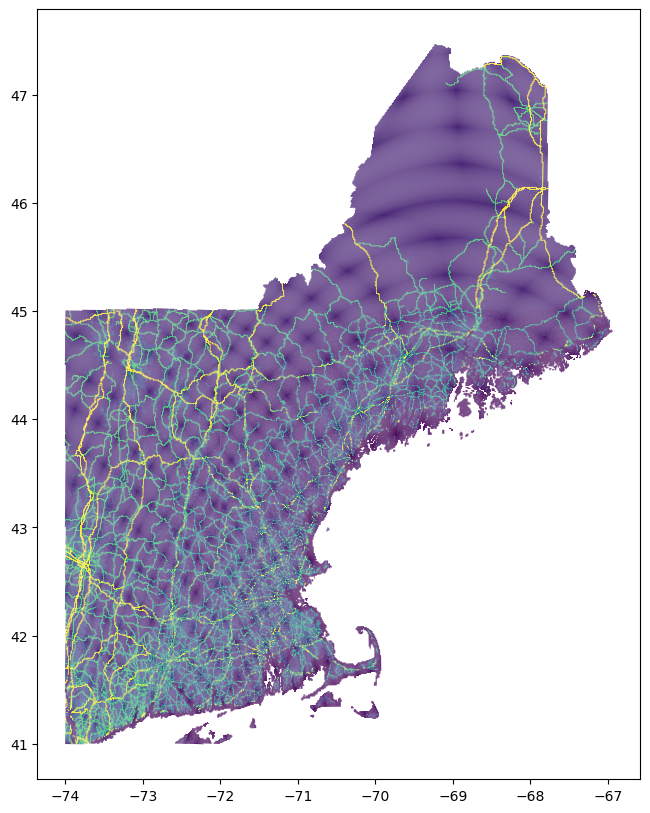

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
game_grid.plot(column='transport_score', ax=ax)
plt.show()

In [42]:
list(us_airfields[us_airfields['name'] == 'Stormville Airport'])

['nodes',
 'FAA:LFSN',
 'addr:state',
 'aeroway',
 'ele',
 'faa',
 'gnis:feature_id',
 'icao',
 'name',
 'start_date',
 'wikidata',
 'wikipedia',
 'geometry',
 'addr:city',
 'addr:housenumber',
 'addr:postcode',
 'addr:street',
 'gnis:county_name',
 'gnis:created',
 'gnis:feature_type',
 'operator',
 'operator:type',
 'alt_name',
 'tc',
 'source',
 'city_served',
 'name:en',
 'iata',
 'closest_town',
 'fixme',
 'old_name',
 'website',
 'aerodrome:type',
 'name:fr',
 'abandoned',
 'note',
 'is_in',
 'type',
 'landuse',
 'military',
 'access',
 'building',
 'elevation',
 'description',
 'phone',
 'source_ref',
 'old',
 'frequency',
 'FAA',
 'addr:place',
 'nohousenumber',
 'owner',
 'tclid',
 'operational_status',
 'boundary',
 'ownership',
 'protected',
 'ref',
 'ways',
 'email',
 'name_1',
 'name:ru',
 'Variation',
 'airport_ref',
 'official_name',
 'sources',
 'area',
 'internet_access',
 'addr:country',
 'contact:facebook',
 'contact:twitter',
 'name:etymology:wikidata',
 'fax',
 'ad

In [10]:
game_grid.total_bounds

array([-74.00627512,  40.99555626, -66.93832921,  47.4662433 ])

In [18]:
# plot_route function now returns the full route as a list of MGRS IDs
def plot_route(game_grid, transport_network, route, ax, buffer=0.01, color=None):
    if color is None:
        color = np.random.random(3)
    full_route = []
    for idx in range(len(route) - 1):
        orig = route[idx]
        dest = route[idx + 1]
        full_route += nx.astar_path(transport_network, orig, dest)
    route_geom = game_grid.set_index('MGRS').loc[full_route]
    route_geom.buffer(buffer).plot(ax=ax, color=color)
    return full_route

def optimize_route(truck_location, destination_type):
    # Find the nearest shelter using the minimize function
    result = minimize(truck_location, destination_type)
    nearest_shelter = result[0]
    
    # Get the full route to the nearest shelter using the plot_route function
    full_route = plot_route(game_grid, transport_network, [truck_location['MGRS'], nearest_shelter], None, buffer=0.01)
    return full_route

# # creating maps here

# truck_location = np.random.choice(game_grid['MGRS'])
# optimized_route = optimize_route(game_grid.loc[game_grid['MGRS'] == truck_location].squeeze(), 'shelter')

# # Plot the optimized route on the map
# fig, ax = plt.subplots(figsize=(10, 10))
# game_grid.plot(column='transport_score', cmap='Greys', alpha=0.8, ax=ax)
# plot_route(game_grid, transport_network, optimized_route, ax, buffer=0.01, color='red')
# ctx.add_basemap(ax, crs=game_grid.crs, source=ctx.providers.Stamen.TonerBackground)
# ax.set_xlim([w, e])  # from overall bounds
# ax.set_ylim([s, n])
# plt.show()

NameError: name 'transport_network' is not defined

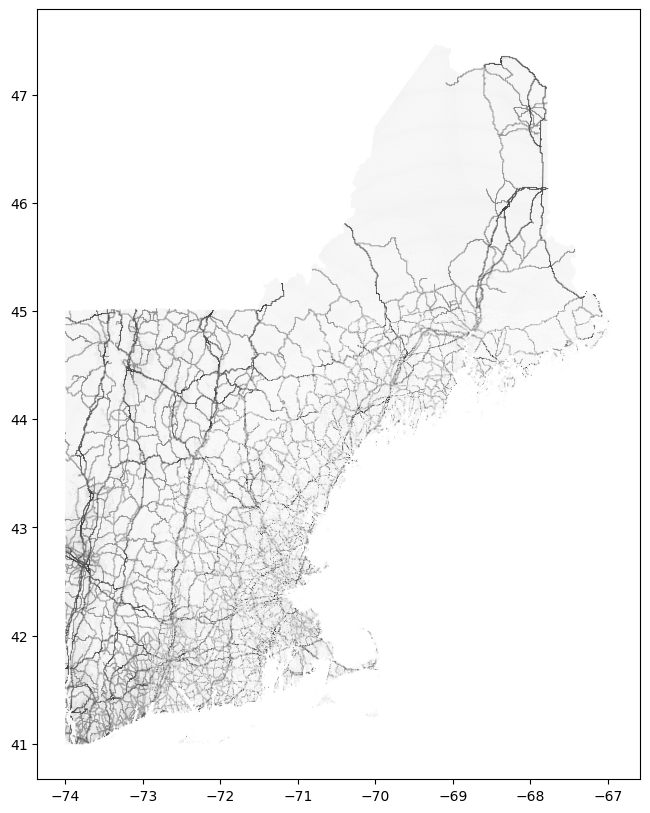

In [19]:
# example of plotting transport score and route
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
game_grid.plot(column='transport_score', cmap='Greys', alpha=0.8, ax=ax)
#plotting for random origin and destination for reference
plot_route(game_grid,
           transport_network, 
           [np.random.choice(game_grid['MGRS']),
            np.random.choice(game_grid['MGRS'])],
           ax=ax,
           buffer=0.01)
ctx.add_basemap(ax,
                crs=game_grid.crs,
                source=ctx.providers.Stamen.TonerBackground)
ax.set_xlim([w,e]) # from overall bounds
ax.set_ylim([s,n])
plt.show()

In [16]:
list_shelters = [
'Chazy Central School',
 'American Legion Post #767',
 'Saranac Central Senior High School',
 'Lamoille Union High School',
 "Saint Anne's Church",
 'Brewster Pierce Memorial High School',
 'Chamberlin Elementary School',
 'Rick Marcotte Central School',
 'Orchard Elementary School',
 'Cold Hollow Career Center',
 'Georgia Elementary And Middle School',
 'Good Shepard Church Of Nazarene',
 'Knights of Columbus',
 'Highgate Elementary School',
 'Altona Correctional Facility ( Quality Of Worklife Bld)',
 'Bellows Free Academy',
 'Burlington School District',
 'Roxbury Village School',
 'Newton School',
 'Stockbridge Central School',
 'Swanton Village Municipal Complex',
 'Bellows Free Academy Fairfax',
 'Morristown Elementary School',
 "Saint Anthony's Roman Catholic Church",
 'Orwell Village School',
 'Lamoille County Senior Citizen Center',
 'Willey Building (town Hall)',
 'Keeseville Country Gardens',
 'Braintree Town Hall',
 'Morrisonville Elementary School',
 'Saint Patricks Church Parish Hall',
 'Waitsfield Elementary School',
 'Barre Auditorium',
 'Plattsburgh Housing Authority - Robert South Long Apartment',
 'Barrett Hall',
 'Saranac Central Junior High School',
 'Champlain Valley Exposition',
 'Saint Albans Town Educational Center',
 'First Congregational Church',
 'Ellenburg Depot Weslyan Church',
 'Tyson Gym',
 'Harwood Uhs #19 School',
 'Holy Angels Church',
 'NORTH HERO TOWN HALL',
 'Former ASAP Office / Moose Lodge (Plattsburgh NY)',
 'Saranac Central Elementary School',
 'Keeseville Fire Department',
 'Churubusco Volunteer Fire Company Inc.',
 'Weslyan Church',
 'Cumberland Head Fire Department',
 'Crossett Brook Middle School',
 'Peru CSD Middle School',
 'Beekmantown Volunteer Fire Department',
 'Church Of The Nazarene',
 'Plattsburgh Housing Authority - Russell Barnard Apts.',
 'Warming Center - Robinson Elementary School',
 'Plattsburgh City SD - High School',
 'SUNY Plattsburgh Memorial Hall',
 'Christ & Saint Johns Espiscopal Church',
 'Beekman Towers',
 "Saint Joseph's Church",
 'Saint Patricks Church Parish Center',
 'Essex Town School District',
 'Essex Middle School',
 'Peru CSD High School',
 'Fredrick H. Tuttle Middle School',
 'First Baptist Church',
 'Fayston Elementary School',
 'Lowell Graded School',
 'Waterbury Congregational Church - The White Meeting Hse',
 'Hinesburg Community School',
 'Lincoln Community School',
 'Leicester Central School',
 'Church Of The Nazarene',
 'Fleming Elementary School',
 'Chelsea Public School',
 'Suny Plattsburgh Clinton Dining Hall',
 'Suny Plattsburgh Angel College Center',
 'Westford School',
 'Charlotte Senior Center',
 'Browns River Middle School',
 'Cabot School',
 'Bristol Elementary School',
 'Ripton Elementary School',
 'Suny Plattsburgh Algonquin Dining Hall',
 'Spaulding High School And Vocational Center',
 "St. Joseph's Center",
 'South Burlington High School',
 'The Norwich Inn',
 'Thatcher Brook Primary School',
 "Saint Anthony's Parish Hall",
 'Memorial Auditorium',
 'St. John the Baptist Church',
 'Mary Hogan Elementary School',
 'Northfield Middle/high School',
 'Northfield Elementary School',
 'Northern Vermont Chapter',
 'North Hero School',
 'Newport Municipal Building',
 'New Haven Town Hall',
 'Peoples Academy',
 'Orange Center School',
 'Willsboro Central School',
 'United Methodist Church',
 'Tracy Hall',
 'Town Of Hardwick Memorial Building',
 "St. Augustine's Catholic Church",
 'Main Street Middle School',
 'Richmond Elementary School',
 'Cadyville Weslyan Church',
 'Cadyville Elementary School',
 'Johnson State College - SHAPE Center',
 'Johnson Elementary School',
 'Union Elementary School',
 'Warren Elementary School',
 'Walden United Methodist Church',
 'PUTNUM CENTRAL SCHOOL',
 'Camels Hump Middle School',
 'Craftsbury Community Care Center',
 'John F Kennedy School',
 "Saint Michael's School",
 'Doty Memorial School',
 'National Life Insurance Company',
 'Benson Village School',
 'Hinesburg Elementary School',
 'Sheldon Elementary School',
 'Shelburne Community School',
 'Heaton Woods Residential Care Home',
 'Winooski School District',
 'Mount Abraham Union Highschool',
 'Moretown Elementary School',
 'Summit Elementary School',
 'Stowe High School',
 'Barre City Elementary And Middle School',
 'Grand Isle United Methodist Church',
 'LAKE PLACID MIDDLE / HIGH SCHOOL',
'Irasburg Village School',
 'Fletcher Town Garage',
 'American Legion Post 55',
 'United Church Of Chelsea',
 "Saint Joseph's Church - Hall",
 'Beekmantown CSD - High School',
 'Smilie Memorial School',
 'Lewis Fire Department',
 'Vermont Police Academy',
 'Yandon - Dillon Education Center',
 'Alburgh Elementary School',
 'Middlebury Municipal Building',
 'Saint Barnabas Episcopal Church',
 'Crown Point Central School District',
 'Sharon Elementary School',
 'Belvidere Central School',
 'Mount Mansfield Union High School',
 'Morrisville American Legion',
 'Essex Alliance Church',
 'Edmunds Middle School',
 'Norrisville American Legion',
 'NY Olympic Regional Development Center',
 'Essex Volunteer Fire Department',
 'Enosburg Falls Elementary School',
 'HAGUE FIRE DEPT',
 'Montgomery Public Safety Building',
 'Barstow Memorial School',
 'Church Of Jesus Christ Of Latter Day Saints',
 'Barre Auditorium',
 'Crete Memorial Civic Center',
 'Vermont Technical College - Judd Hall',
 'Keene Valley Hose And Ladder Company #1',
 'Charles P. Smith Elementary School',
 'Rochester School',
 "St. Augustine's Parish Hall",
 'Clinton Correctional Facility (quality Of Worklife Bld.',
 'Adirondack Christian School',
 'Evac Center - Missisquoi Valley Union High School',
 'Assembly Of God Christian Center',
 'Albany Community School',
 'Elizabethtown - Lewis Central School',
 'Albert D. Lawton Intermediate School',
 'Upper Jay Volunteer Fire Department',
 'Mental Health Association In Essex County Inc.',
 'Suny Plattsburgh Fieldhouse',
 'WARMING-Schroon Lake Fire Department',
 'Ferrisburgh Central School',
 'Hardwick Elementary School',
 'Middlebury College',
 'Stowe Elementary School',
 'Milton Elementary School',
 'Binghamville United Methodist Church',
 'Hiawatha Elementary School',
 'Rescue House #5 Volunteer Fire Department',
 'Wolcott Town Offices',
 'Westport Central School',
 'Cold Hollow Career Center',
 'Berkshire Elementary School',
 'Champlain Valley Union High School',
 'TICONDEROGA CENTRAL SCHOOL DISTRICT',
 'Bridport Central School',
 'Moriah Central School',
 'Northern Adirondack Central Middle/ High Schoolntr',
 'Essex High School/Essex Community Educational Center',
 'Monkton Central School',
 'Warming Center--PUTNAM VALLEY SENIOR CENTER',
 'United Reform Church',
 'New Haven Fire Station',
 'Woodbury Elementary School',
 'North Hyde Park Grange Hall',
 'Catholic Center At Uvm',
 'Randolph Union High School',
 'Warren Town Hall',
 'North Chittenden Grange Hall',
 'Marion Cross School',
 'Winooski Middle/high School',
 'Lamoille County Civic Association',
 'Lowell Congregational Church',
 'Bakersfield Elementary School',
 'Enosburg Falls Middle/high School',
 'Saint John The Baptist Rc Church Hall',
 'Colchester High School',
 'Colchester Middle School',
 'United Church Of Colchester',
 'Elizabethtown Volunteer Fire Department',
 'St. Albans City Hall',
 'Winooski Educational Center',
 'Greensboro Town Hall',
 'Community Church of Huntington',
 'Fairfield Center School',
 'Huntington Fire Station',
 'St. Joseph Church - Religious Education Building',
 'Northeastern Clinton Central Middle School',
 'Wswhe Boces School',
 'Village of Dannemora Community Building',
 'Cornwall Town Hall',
 'Vergennes Fire Station',
 'Essex Fire Station',
 'Essex Junction Municipal Building',
 "Winooski 'O'Brien Community Center",
 'Warming Center - Eden School',
 'Elmore Fire Station',
 'Elmore Elementary School',
 'Waterville Elementary School',
 'Mennonite School',
 'Whallonsburg Grange Hall',
 "St. Gabriel's Catholic Church",
 'Waterville Town Hall',
 "St. Isidore's Parish Hall",
 'Time After Time Receptions,LLC',
 'Beekmantown CSD - Middle School',
 'Montgomery Public Works Building',
 'North Country Union High School',
 'Good Shepherd Church of the Nazarene',
 'Jay Town Hall & Community Center',
 'Vershire Town Center Building/Rivendell Interstate Schl',
 'Craftsbury Academy Gymnasium',
 'AuSable Valley Keeseville Elementary',
 'AuSable Valley High / Middle School',
 'AuSable Valley Au Sable Forks Elementary School',
 'Cambridge Elementary School',
 'Whitehall Central School District',
 'Charlotte Central School',
 'Richard W Black Center',
 'Dartmouth College Leverone Field House',
 'Thatcher Brook Elementary',
 'Ellenburg Depot Fire Department',
 'Keene Central School',
 'Addison Central School',
 'White RIver Valley School- Bethel Campus',
 'Champlain Volunteer Fire Department',
 'Essex Elementary School',
 'Essex Alliance Church',
'Underhill Central School',
 'Town Of Jay Community Center',
 'Burlington High School',
 'Underhill Town Hall',
 'Beeman Elementary School',
 'North Hero Community Hall',
 'Jericho Elementary School',
 'Montgomery Town Hall',
 'United Church Of Strafford',
 'Wolcott Elementary School',
 'Orwell Fire House',
 'Monkton Volunteer Fire Dept.',
 'Neshobe School',
 'North Chittenden Grange Hall',
 'Albany United Methodist Church',
 'Thetford Elementary School',
 'Williamstown High School',
 'Hancock Town Hall',
 'Community Center of Goddard College',
 'Lake Placid Baptist Church',
 'Goshen Town Hall',
 'Cuba Middle School',
 'Alburgh Volunteer Fire Department Bingo Hall',
 'Isle La Motte Elementary School',
 'Royalton Academy Community Building',
 'Edmunds Elementary School',
 'Hanover High School',
 'Cabot Highway Department Building',
 "St. Michael's College",
 'Middlebury Recreation Center',
 'National Guard Armory',
 'National Guard Armory',
 'National Guard Armory',
 'National Guard Armory',
 'Middlebury Recreational Center',
 'Titherington Properties Building (Old Moose Lodge)',
 'Port Henry Central School',
 'Cooling Center - Fletcher Free Library',
 'Cooling Center - Robert Miller Com and Rec Center',
 'Cooling Center - Burlington Police Department',
 'Cooling Center - Hinesburg Fire Department',
 'Cooling Center - Bristol Fire Department',
 'Cooling Center - Bristol Town Offices',
 'Cooling Center - Capitol Region Visitors Center',
 'Cooling Center - Montpelier City Hall',
 'Cooling Center - Montpelier Senior Center',
 'Cooling Center - State House',
 'Schroon Lake Central School',
 'Cooling Center - Randolph Village Fire Department',
 'Pomfret Town Hall',
 'TEST - Bernard Volunteer Fire Dept',
 'Warming Center - National Guard Armory',
 'Champlain College Argosy Gym',
 'Cooling Center - Barre City Hall',
 'Cooling Center - Aldrich Library',
 'Cooling Center - Faith Community Church',
 'Cooling Center - Scampers',
 'Cooling Center - Waterbury Public Library',
 'Cooling Center - Montpelier Police Dept.',
 'Med Surge - Mass Care Barre Municipal Auditorium',
 'Otter Valley UMHS',
 'Coventry Community Center',
 'Barre Town Middle & Elementary School',
 'WARMING-Schroon Lake Town Hall',
 'Potterville Fire Department',
 'Bolton Fire Dept'
 'Milton Graded School District',
 'Middlebury Union High School',
 'Middlebury American Legion Post 27',
 'Trinity Episcopal Church',
 'Seton Academy School',
 'Allen Brook School',
 'Walden School',
 'First Baptist Church',
 'E Craftsbury Presbyterian Church',
 'United Church Of Newport',
 'Braintree Elementary School',
 'Rumney School',
 'John J Flynn Elementary School',
 'Barre Auditorium',
 'Ellenburg Center Fire Department',
 'Lyman C. Hunt Middle School',
 'Hyde Park Elementary School',
 'Lawrence Barnes School',
 'Champlain Elementary School',
 'Coventry Village School',
 'Franklin Central School',
 'Founders Memorial School',
 'Folsom Educational And Community Center',
 'Grand Isle School',
 'Wheeler Elementary School',
 'Weybridge Elementary School',
 'Hubbardton Town Hall',
 'Cathedral Church Of St. Paul Episcopal',
 'Colchester School District',
 'Fletcher Union Meeting House',
 'Fletcher Elementary School',
 'First United Methodist Church',
 'First Church Of Christian Scientist',
 'Underhill I.D. School',
 'Trinity Methodist Church',
 'Trinity College',
 'Williston Central School',
 'Montogomery Elementary School',
 'Essex Center for Rehab and Healthcare',
 'Peru Knights Of Columbus #7273',
 "Saint Luke's Epscopal Church",
 'Shoreham School',
 'Salisbury Community School',
 'Beth - Jacob Synagogue',
 'Berlin Elementary School',
 'Bailey Avenue Elementary School',
 'Milton High School',
 'Champlain Valley Education Services ( Cves )',
 'Plattsburgh Housing Authority - Lakeview Towers',
 'Northern Adirondack Elementary School',
 'Advocacy And Resource Center',
 'Plattsburgh City SD - Stafford Middle School',
 'Momont Elementary School',
 'TICONDEROGA TOWN HALL',
 'Minerva Central School',
 'American Legion Post #20',
 'Moretown Town Hall',
 'Northeastern Clinton High School',
 'Ticonderoga Community Center (The Armory)',
 'TICONDEROGA HIGH SCHOOL',
 'Duken School District Office',
 'Assumption Of Mary School',
 'Warren Fire House',
 'Ticonderoga Elementary & Middle School',
 'Oak Street Elementary School',
 'Elizabeth Street Weslyan Church',
 'Knights Of Columbus #2366',
 'East Montpeilier Elementary School',
]

In [53]:
def random_color():
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
    return color

In [20]:
#create geodataframe with desired airports
airport_list = ['Westover Air Reserve Base', 'Berlin Municipal Airport', 'Rutland-Southern Vermont Regional Airport', 'Newton Field', 'Stormville Airport'] #replace list with list of names
names_of_airports = pd.DataFrame({'name': airport_list})
selected_airfields_gdf = us_airfields.reset_index().merge(names_of_airports, how = 'inner', on = 'name')

#geodataframe of selected shelters (switched from day1 to day2)
names_of_shelters = pd.DataFrame({'name': list_shelters})
selected_shelters_no_add = shelters_gdf.merge(names_of_shelters, how = 'inner' , left_on = 'SHELTER_NAME', right_on = 'name')
additional_shelters = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final/additional_shelters_to_supply_2023.geojson')
selected_shelters = pd.merge(selected_shelters_no_add, additional_shelters, how='outer')
#selected_shelters = selected_shelters_no_add.sjoin(additional_shelters, how='outer')

#create geodataframe of hurricane paths 
# paths_arr = []
# for pred_id, pred in day2_forecast.groupby('prediction'):
#     line_to_plot = LineString(pred.geometry.values)
#     paths_arr.append({'prediction': pred_id, 'geometry':line_to_plot})
# paths_df = gpd.GeoDataFrame(paths_arr)

#create geodataframe using cone of uncertainty (invalid for day 2)
# cone_of_uncertainty = gpd.GeoDataFrame(geometry = [all_forecasts])
# cone_of_uncertainty.loc[0, 'hurricane'] = 'hurricane'
# Reset map variable
airmap = folium.Map()

# hospitals_gdf['affected?'] = #shapely.intersects(hospitals_gdf['geometry'], polygon)
# shelters_gdf['affected?'] = #shapely.intersects(shelters_gdf['geometry'], polygon)
# us_airfields['affected?'] = #shapely.intersects(us_airfields['geometry'], polygon)

# Add hospital, shelter, and airfield data
# airmap = hospitals_gdf[['ID', 'NAME','ADDRESS','STATE','geometry']].explore(m=airmap, color = 'red', name= 'hospitals', style_kwds = {'weight':.3})
# airmap = shelters_gdf[['SHELTER_ID','SHELTER_NAME','ADDRESS_1','STATE','geometry']].explore(m=airmap, color = 'blue', name= 'shelters', style_kwds = {'weight':.3})
# airmap = us_airfields[['geometry', 'addr:state', 'aeroway', 'faa','name']].explore(m=airmap, name= 'airfields', color = 'green', style_kwds = {'weight':2})
# airmap = selected_airfields_gdf[['geometry', 'addr:state', 'aeroway', 'faa','name']].explore(m= airmap, name= 'distribution centers', color = 'brown', style_kwds = {'weight':10})
# airmap = selected_shelters[['SHELTER_ID','SHELTER_NAME','ADDRESS_1','STATE','geometry']].explore(m= airmap, name= 'shelters_selected', color = '#0ca6a1', style_kwds = {'weight':3})

#add hurricane path
# airmap = day2_forecast[['prediction','forecastHour','maxWinds','category','geometry']].explore('prediction', m = airmap, name = 'points', legend = False) #changed from day 1 to day 2
# airmap = paths_df.explore('prediction', m= airmap, name= 'paths')

#add hurricane shape
#airmap = cone_of_uncertainty.explore(m=airmap, color = 'yellow', style_kwds = {'opacity':.22, 'fillOpacity':.22, 'fillColor': 'yellow'}, name = 'storm')

# Add bounding box
bounding_box_gdf = folium.Rectangle([[s,w],[n,e]]) 
airmap.add_child(bounding_box_gdf)

# Set default bounds
airmap.fit_bounds([[s,w],[n,e]]) 

#add layers
folium.LayerControl().add_to(airmap)
airmap

In [21]:
type(selected_shelters)

geopandas.geodataframe.GeoDataFrame

In [56]:
# Algorithm
selected_hospitals = gpd.read_file("https://files.bwsi-remote-sensing.net/data/final/hospitals_to_supply_2023.geojson")

names = ['Westover Air Reserve Base', 'Berlin Municipal Airport', 'Stormville Airport', 'Rutland-Southern Vermont Regional Airport', 'Newton Field'] #replace list with list of names
resources = [97500-10800, 37500-10800, 45000-13200, 22500-8400, 7500-4800]
names_of_airport = pd.DataFrame({'name': names, 'resources': resources})
centers = us_airfields.merge(names_of_airport, how = 'inner', on = 'name')
centers = centers.sjoin(game_grid, how = 'inner', predicate='intersects')
centers = centers.drop_duplicates('name')

center = centers.iloc[0]['MGRS']

trucks = pd.DataFrame(columns=['resources', 'time', 'total_time', 'start', 'color'])
for i in range(9):
    trucks.loc[len(trucks.index)] = [1200, 720, 720, centers.iloc[2]['MGRS'], random_color()]
for i in range(9):
    trucks.loc[len(trucks.index)] = [1200, 720, 720, centers.iloc[1]['MGRS'], random_color()]
for i in range(11):
    trucks.loc[len(trucks.index)] = [1200, 720, 720, centers.iloc[4]['MGRS'], random_color()]
for i in range(7):
    trucks.loc[len(trucks.index)] = [1200, 720, 720, centers.iloc[3]['MGRS'], random_color()]
for i in range(4):
    trucks.loc[len(trucks.index)] = [1200, 720, 720, centers.iloc[0]['MGRS'], random_color()]
centers['resources']
#     print(trucks[i]['start']['MGRS'])

0     2700
1    26700
2    86700
3    14100
4    31800
Name: resources, dtype: int64

In [57]:
#update hospital, shelter, and airfield data (uses planning team data, invalid for day 2)
# hospitals_gdf['affected?'] = shapely.intersects(hospitals_gdf['geometry'], all_forecasts)
# shelters_gdf['affected?'] = shapely.intersects(shelters_gdf['geometry'], all_forecasts)
# us_airfields['affected?'] = shapely.intersects(us_airfields['geometry'], all_forecasts)

#add msrg indicies
shelter_select = selected_shelters.sjoin(game_grid, how = "left", predicate = "intersects")
shelter_select = shelter_select.drop_duplicates('SHELTER_ID')
hospital_select = selected_hospitals.sjoin(game_grid, how = "left", predicate = "intersects")
hospital_select = hospital_select.drop_duplicates('ID')
# airfields_merged = us_airfields.sjoin(game_grid, how ='left', predicate = "intersects")
# airfields_merged = airfields_merged.reset_index().drop_duplicates('osmid')

# #create geodataframe with desired airports
# airport_list = ['Westover Air Reserve Base', 'Berlin Municipal Airport', 'Stormville Airport', 'Rutland-Southern Vermont Regional Airport', 'Newton Field']
# names_of_airports = pd.DataFrame({'name': airport_list})
# selected_airfields_gdf = airfields_merged.reset_index().merge(names_of_airports, how = 'inner', on = 'name')

# #geodataframe of selected shelters (switched from day1 to day2)
# names_of_shelters = pd.DataFrame({'name': list_shelters})
# selected_shelters_gdf = shelters_merged.merge(names_of_shelters, how = 'inner' , left_on = 'SHELTER_NAME', right_on = 'name')

#create geodataframe of hurricane paths 
# paths_arr = []
# for pred_id, pred in day1_forecast.groupby('prediction'):
#     line_to_plot = LineString(pred.geometry.values)
#     paths_arr.append({'prediction': pred_id, 'geometry':line_to_plot})
# paths_df = gpd.GeoDataFrame(paths_arr)

# paths_arr2 = []
# for pred_id, pred in day2_forecast.groupby('prediction'):
#     line_to_plot = LineString(pred.geometry.values)
#     paths_arr2.append({'prediction': pred_id, 'geometry':line_to_plot})
# paths_df_2 = gpd.GeoDataFrame(paths_arr2)

# #create geodataframe using cone of uncertainty (invalid for day 2)
# cone_of_uncertainty = gpd.GeoDataFrame(geometry = [all_forecasts])
# cone_of_uncertainty.loc[0, 'hurricane'] = 'hurricane'
#Reset map variable
# airmap = folium.Map()

# # Add hospital, shelter, and airfield data
# # airmap = hospitals_merged[['ID', 'NAME','ADDRESS','STATE','geometry', 'MGRS']].explore(m=airmap, color = 'red', name= 'hospitals', style_kwds = {'weight':.3})
# # airmap = shelters_merged[['SHELTER_ID','SHELTER_NAME','ADDRESS_1','STATE','geometry', 'MGRS']].explore(m=airmap, color = 'blue', name= 'shelters', style_kwds = {'weight':.3})
# # airmap = airfields_merged[['geometry', 'addr:state', 'aeroway', 'faa', 'name', 'MGRS']].explore(m=airmap, name= 'airfields', color = 'green', style_kwds = {'weight':2})
# airmap = selected_airfields_gdf[['geometry', 'addr:state', 'aeroway', 'faa', 'name', 'MGRS']].explore(m= airmap, name= 'distribution centers', color = 'brown', style_kwds = {'weight':10})
# airmap = selected_shelters_gdf[['SHELTER_ID','SHELTER_NAME','ADDRESS_1','STATE','geometry', 'MGRS']].explore(m= airmap, name= 'shelters_selected', color = '#0ca6a1', style_kwds = {'weight':3})

# #add hurricane path
# #airmap = day2_forecast[['prediction','forecastHour','maxWinds','category','geometry']].explore('prediction', m = airmap, name = 'points', legend = False) #changed from day 1 to day 2
# # airmap = paths_df.explore(m= airmap, name= 'd1paths', color = 'yellow') #'prediction'
# # airmap = paths_df_2.explore(m= airmap, name= 'd2paths', color = 'purple')

# #add hurricane shape
# #airmap = cone_of_uncertainty.explore(m=airmap, color = 'yellow', style_kwds = {'opacity':.22, 'fillOpacity':.22, 'fillColor': 'yellow'}, name = 'storm')

# # Add bounding box
# bounding_box_gdf = folium.Rectangle([[s,w],[n,e]]) 
# airmap.add_child(bounding_box_gdf)

# # Set default bounds
# airmap.fit_bounds([[s,w],[n,e]]) 

# #add layers
# folium.LayerControl().add_to(airmap)
# airmap

In [58]:
def minimize(orig, destination, start): #ORIG represents the starting node, DESTINATION reprsents what type of location you want to find the closest of 
    ret = [] #ELEMENT 0 will be the NODE ID of the CLOSEST destination type (str format), ELEMENT 1 represents the time in minutes to get from orig to said node
    #print(orig['name'])
    #print('and')
    #print(orig['MGRS'])
    if destination == 'hospital':
        if len(hospital1) == 0:
            ret.append(None)
            ret.append(float('inf'))
        closest_path_length = nx.shortest_path_length(transport_network, orig, hospital1.iloc[0]['MGRS'])
        closest_hospital = hospital1.iloc[0]
        for hospital_node_id in hospital1['MGRS'].index: #for testing you can can slice the column
            hospital_node = hospital1.loc[hospital_node_id]
            try: #try except is necessary because there are combinations of nodes that do not have a path between them
                if (nx.shortest_path_length(transport_network, orig, hospital_node['MGRS'])<closest_path_length):
                    closest_hospital = hospital_node
                    closest_path_length = min(nx.shortest_path_length(transport_network, orig, hospital_node['MGRS']), closest_path_length)
            except:
                pass
        print('closest')
        print(closest_hospital)
        print('and')
        print(closest_hospital['MGRS'])
        ret.append(closest_hospital['MGRS'])
        ret.append(closest_path_length)
        return ret
    elif destination == 'shelter':
        if len(shelter1) == 0:
            ret.append(None)
            ret.append(float('inf'))
        closest_path_length = nx.shortest_path_length(transport_network, orig, shelter1.iloc[0]['MGRS'])
        closest_shelter = shelter1.iloc[0]
        for shelter_node_id in shelter1.index:
            shelter_node = shelter1.loc[shelter_node_id]
            #print(shelter_node)
            try:
                if nx.shortest_path_length(transport_network, orig, shelter_node['MGRS'])<closest_path_length:
                    closest_shelter = shelter_node
                    closest_path_length = min(nx.shortest_path_length(transport_network, orig, shelter_node['MGRS']), closest_path_length)
            except:
                pass
        ret.append(closest_shelter['MGRS'])
        ret.append(closest_path_length)
        return ret
    elif destination == 'center':
        closest_path_length = nx.shortest_path_length(transport_network, orig, centers.iloc[0]['MGRS'])
        closest_center = centers.iloc[0]
        closest_id = 0
        for center_node_id in centers.index:
            center_node = centers.loc[center_node_id]
            try:
                if center_node['MGRS'] != start and nx.shortest_path_length(transport_network, orig, center_node['MGRS'])<closest_path_length:
                    closest_center = center_node
                    closest_id = center_node_id
                    closest_path_length = min(nx.shortest_path_length(transport_network, orig, center_node['MGRS']), closest_path_length)
            except:
                pass
        ret.append(closest_id)
        ret.append(closest_center['MGRS'])
        ret.append(closest_path_length)
        return ret
    
def restock(center_id, truck_id):
    truck = trucks.loc[truck_id]
    center = centers.loc[center_id]
    trucks.loc[truck_id, 'time'] = 720
    trucks.loc[truck_id, 'total_time'] += 720
    trucks.loc[truck_id, 'start'] = center['MGRS']
    if(center['resources'] > (1200 - truck['resources'])):
        centers.loc[center_id, 'resources'] -= (1200 - truck['resources'])
        trucks.loc[truck_id, 'resources'] = 1200
    else:
        trucks.loc[truck_id, 'resources'] = truck['resources'] + center['resources']
        centers.loc[center_id, 'resources'] = 0

def deliver(isShelter, time, places_to_choose, place, truck_id):
    truck = trucks.loc[truck_id]
    if isShelter:
        trucks.loc[truck_id, 'resources'] -= 200
        trucks.loc[truck_id, 'time'] -= (time + 20)
        #print(place['SHELTER_NAME'] + " took " + (truck['total_time'] - truck['time']) + " to get resources");
        trucks.loc[truck_id, 'start'] = place
        print(len(places_to_choose))
        places_to_choose = places_to_choose[places_to_choose['MGRS'] != place]
        print(len(places_to_choose))
        return places_to_choose
    else:
        trucks.loc[truck_id, 'resources'] -= 500
        trucks.loc[truck_id, 'time'] -= (time + 60)
        #plot_route(game_grid, transport_network, [truck['start'], place], ax=ax, buffer=0.01)
        #print(place['name'] + " took " + (truck['total_time'] - truck['time']) + " to get resources");
        trucks.loc[truck_id, 'start'] = place
        print(len(places_to_choose))
        places_to_choose = places_to_choose[places_to_choose['MGRS'] != place]
        print(len(places_to_choose))
        return places_to_choose
        # hospital1 = places_to_choose[places_to_choose['MGRS'] != place]

In [ ]:
# Without a priority queue

count = 0
hospital1 = hospital_select
shelter1 = shelter_select
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
game_grid.plot(column='transport_score', cmap='Greys', alpha=0.8, ax=ax)
centers.plot(color='red', alpha=0.8, ax=ax)
# shelter1.plot(color='blue', alpha=0.8, ax=ax)
#hospital1.plot(color='green', alpha=0.8, ax=ax)
truck_id = 0
while(trucks.iloc[0]['total_time'] < 1440 or trucks.iloc[0]['time'] < 10):
    #for truck_id in trucks.index:
    truck = trucks.loc[truck_id]
    print(count)
    print(truck_id)
    print(truck)
    count = count + 1
    if(truck['resources'] < 200):
        center_id, center, small_time = minimize(truck['start'], 'center', truck['start'])
        trucks.loc[truck_id, 'time'] -= small_time
        restock(center_id, truck_id)
        plot_route(game_grid, transport_network, [truck['start'], center], ax=ax, buffer=0.01)
        print('restock norm')
    elif(truck['resources'] < 500):
        #print(truck['start']['MGRS'])
        closest_shelt, smallest_time = minimize(truck['start'], 'shelter', truck['start'])
        #print('then')
        #print(closest_shelt)
        shelter_to_go = shelter1[shelter1['MGRS'] == closest_shelt]
        #print(shelter_to_go)
        if ((smallest_time + 20 + minimize(shelter_to_go, 'center', truck['start'])[2]) > truck['time']):
            center, small_time = minimize(truck['start'], 'center', truck['start'])
            trucks.loc[truck_id, 'time'] -= small_time
            restock(center, truck_id)   
            plot_route(game_grid, transport_network, [truck['start'], center], ax=ax, buffer=0.01)
            print('restock <500')
        else:
            shelter1 = deliver(True, smallest_time, shelter1, shelter_to_go, truck_id)
            plot_route(game_grid, transport_network, [truck['start'], shelter_to_go], ax=ax, buffer=0.01)
            print('shelter < 500')
    else:
        closest_shelt, shelt_time = minimize(truck['start'], 'shelter', truck['start'])
        closest_hosp, hosp_time = minimize(truck['start'], 'hospital', truck['start'])
        print(shelt_time)
        print(hosp_time)
        if shelt_time <= hosp_time and (shelt_time + 20 + minimize(closest_shelt, 'center', truck['start'])[2]) < truck['time']:
            shelter1 = deliver(True, shelt_time, shelter1, closest_shelt, truck_id)
            plot_route(game_grid, transport_network, [truck['start'], closest_shelt], ax=ax, buffer=0.01)
            print(closest_shelt)
        elif hosp_time < shelt_time and (hosp_time + 60 + minimize(closest_hosp, 'center', truck['start'])[2]) < truck['time']:
            hospital1 = deliver(False, hosp_time, hospital1, closest_hosp, truck_id)
            plot_route(game_grid, transport_network, [truck['start'], closest_hosp], ax=ax, buffer=0.01)
            print('hosp')
        else:
            center_id, center, small_time = minimize(truck['start'], 'center', truck['start'])
            trucks.loc[truck_id, 'time'] -= small_time
            restock(center_id, truck_id)
            plot_route(game_grid, transport_network, [truck['start'], center], ax=ax, buffer=0.01)
            print('restock norm')   
#ctx.add_basemap(ax,crs=game_grid.crs,source=ctx.providers.Stamen.TonerBackground)
ax.set_xlim([w,e]) # from overall bounds
ax.set_ylim([s,n])   
plt.show()

0
0
resources          1200
time                720
total_time          720
start         18TYM0473
color         [#1C327B]
Name: 0, dtype: object
closest
OBJECTID                                                        2475
ID                                                        0012801109
NAME                 VIBRA HOSPITAL OF WESTERN MASS - CENTRAL CAMPUS
ADDRESS                                            1400 STATE STREET
CITY                                                     SPRINGFIELD
STATE                                                             MA
ZIP                                                            01109
ZIP4                                                   NOT AVAILABLE
TELEPHONE                                             (413) 787-6700
TYPE                                                  LONG TERM CARE
STATUS                                                          OPEN
POPULATION                                                       127
COUNTY           

/tmp/ipykernel_2802/1613734590.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  route_geom.buffer(buffer).plot(ax=ax, color=color)


18TYM0067
1
0
resources          1000
time                694
total_time          720
start         18TYM0067
color         [#1C327B]
Name: 0, dtype: object
closest
OBJECTID                                                        2475
ID                                                        0012801109
NAME                 VIBRA HOSPITAL OF WESTERN MASS - CENTRAL CAMPUS
ADDRESS                                            1400 STATE STREET
CITY                                                     SPRINGFIELD
STATE                                                             MA
ZIP                                                            01109
ZIP4                                                   NOT AVAILABLE
TELEPHONE                                             (413) 787-6700
TYPE                                                  LONG TERM CARE
STATUS                                                          OPEN
POPULATION                                                       127
COUNTY 

/tmp/ipykernel_2802/1613734590.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  route_geom.buffer(buffer).plot(ax=ax, color=color)


hosp
2
0
resources           500
time                632
total_time          720
start         18TYM0266
color         [#1C327B]
Name: 0, dtype: object
